In [56]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Performance measures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report

# Compsci 361 Assignment 3

## Task 1: Exploratory data analytics on text data


### a) 

In [2]:
data_X = pd.read_csv("train.csv")
data_y = pd.read_csv("test.csv")


tfid = TfidfVectorizer()
tfid.fit(data_X["Text"])

tfidDF = tfid.transform(data_X["Text"])

#number of articles and features
num_articles = tfidDF.shape[0]
num_features = tfidDF.shape[1]

print(f"Number of articles: {num_articles}")
print(f"Number of extracted features: {num_features}")

#5 example articles
fivearticles = data_X["Text"].head(5)
features = tfidDF[:5].toarray()
feature_names = tfid.get_feature_names_out()

example_df = pd.DataFrame(features, columns=feature_names, index=fivearticles)

print(example_df.head())

Number of articles: 428
Number of extracted features: 13518
                                                     00       000  000th  \
Text                                                                       
lifestyle governs mobile choice faster better f...  0.0  0.020115    0.0   
french honour director parker british film dire...  0.0  0.000000    0.0   
fockers fuel festive film chart comedy meet foc...  0.0  0.000000    0.0   
housewives lift channel 4 ratings debut us tele...  0.0  0.000000    0.0   
u2 desire number one u2 three prestigious gramm...  0.0  0.000000    0.0   

                                                    001st  0051  007  0100  \
Text                                                                         
lifestyle governs mobile choice faster better f...    0.0   0.0  0.0   0.0   
french honour director parker british film dire...    0.0   0.0  0.0   0.0   
fockers fuel festive film chart comedy meet foc...    0.0   0.0  0.0   0.0   
housewives lift c

In [3]:
data_X["Category"].unique()

array(['tech', 'entertainment'], dtype=object)

For these articles, we peformed vectorisation using inverse document frequency as a way of tokenising the texts. From this, we observed 13518 unique words becoming our features from 428 articles.

### b)


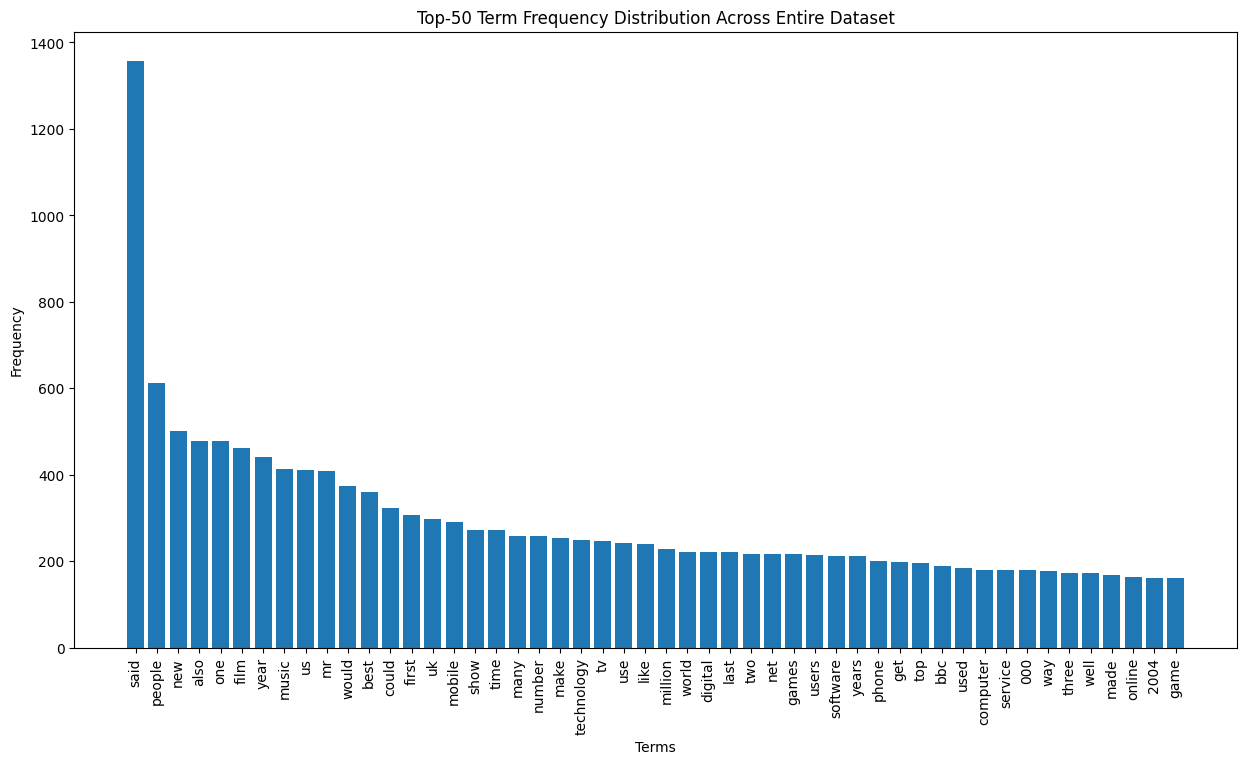

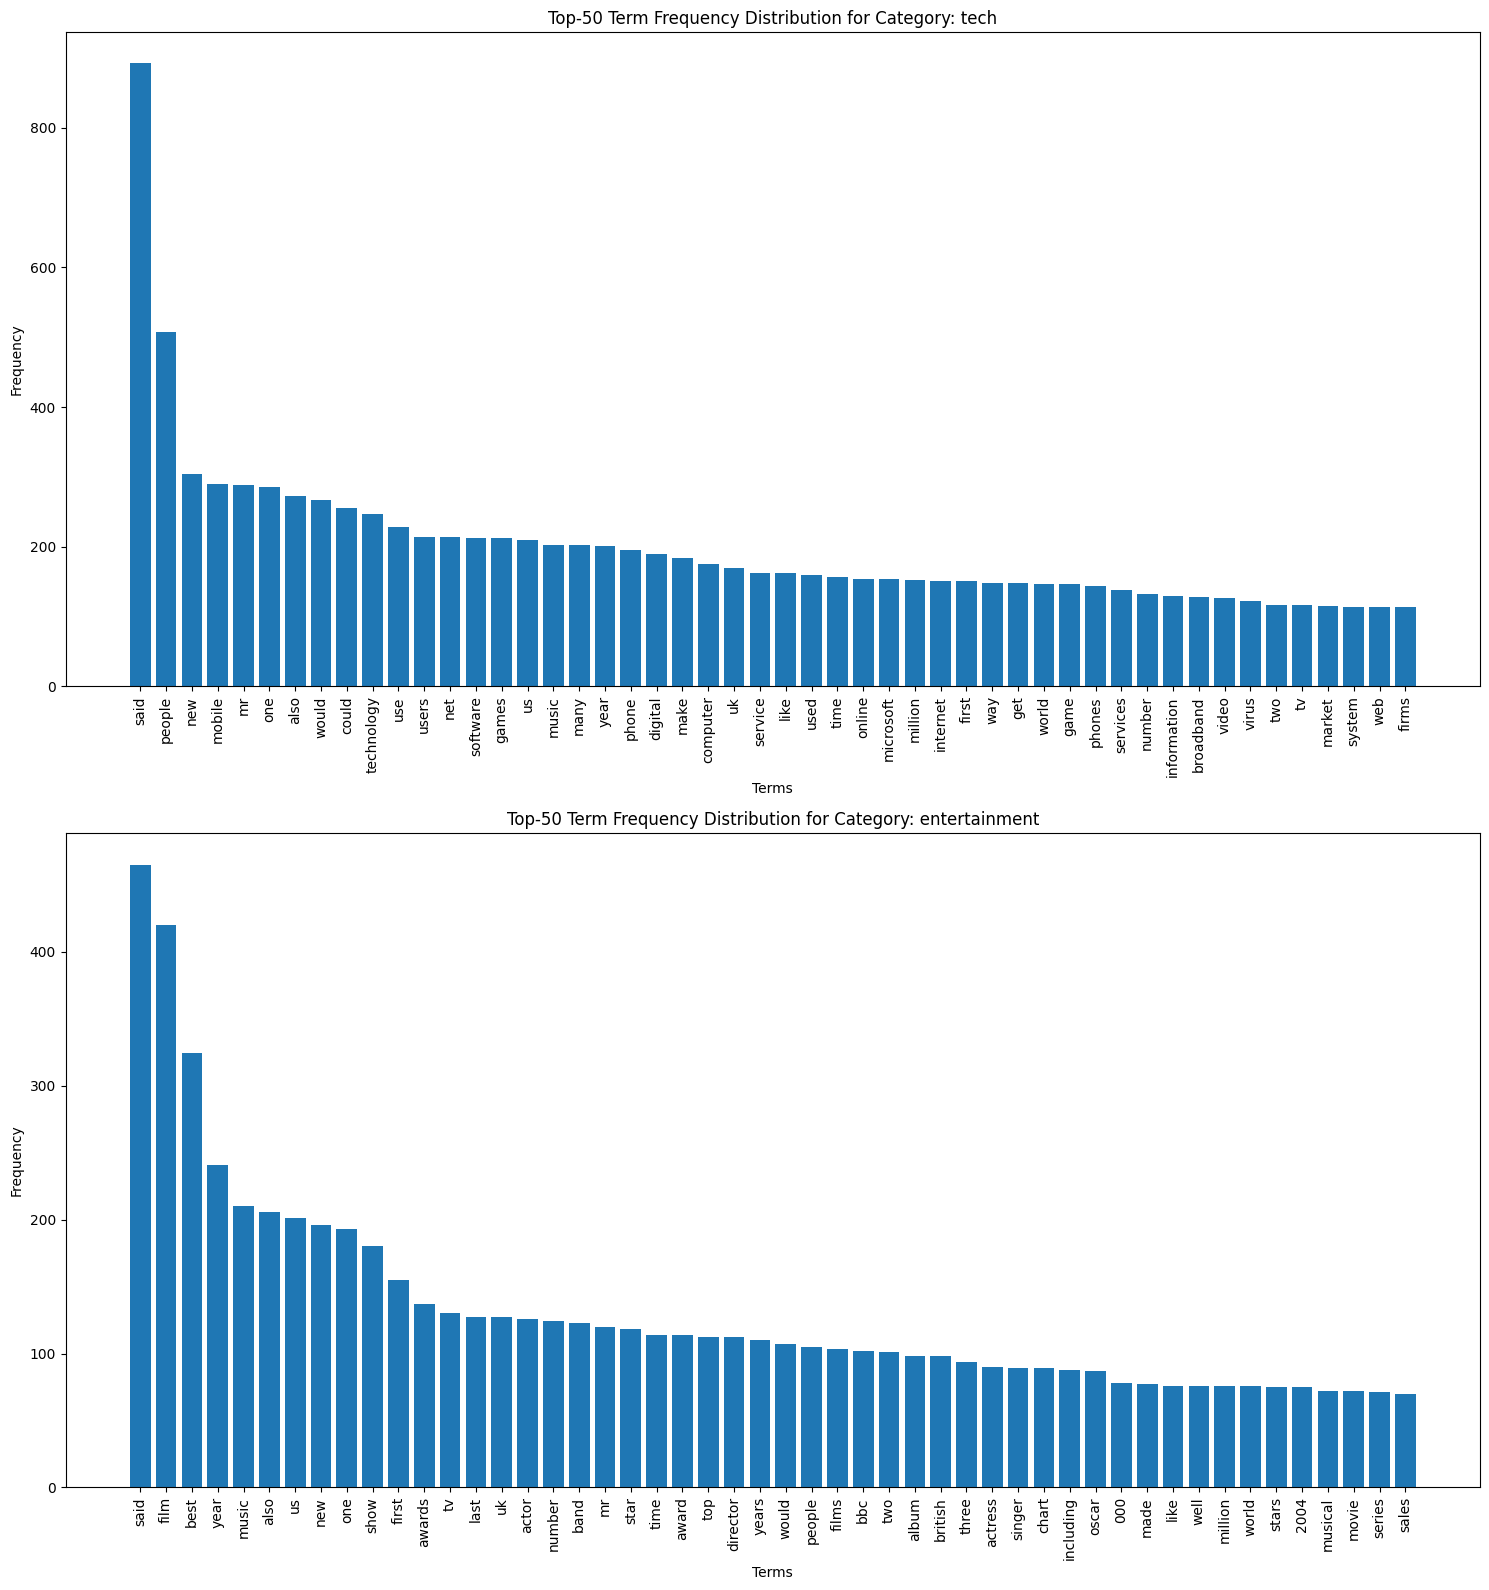

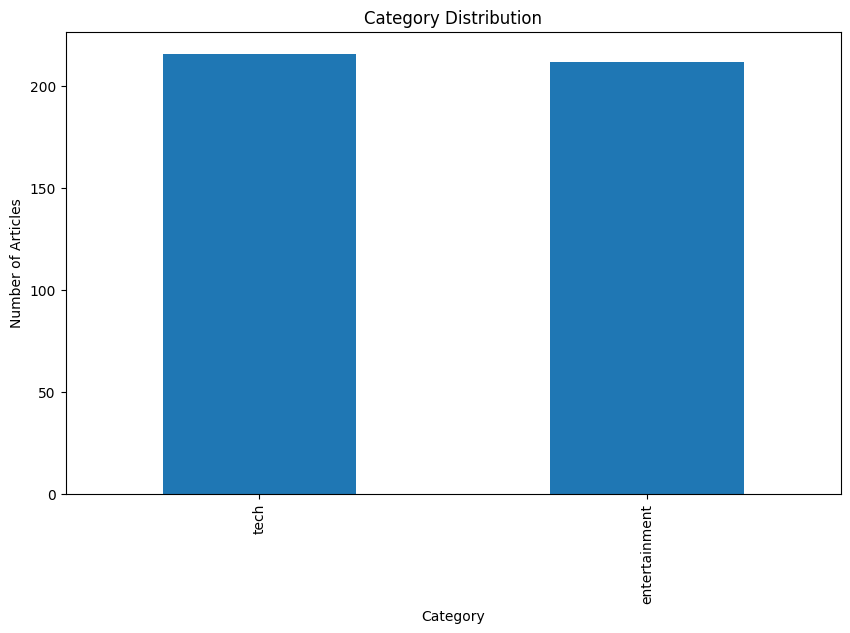

In [8]:


vectorizer = CountVectorizer()

word_matrix = vectorizer.fit_transform(data_X["Text"])
word_hz = word_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame({'term': terms, 'frequency': word_hz})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

#plot 1
plt.figure(figsize=(15, 8))
top50 = term_freq_df.head(50)
plt.bar(top50['term'], top50['frequency'])
plt.xticks(rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution Across Entire Dataset')
plt.show()

categories = data_X['Category'].unique()
term_hz = {}

for category in categories:
    category_texts = data_X[data_X['Category'] == category]['Text']
    category_word_matrix = vectorizer.transform(category_texts)
    category_word_hz = category_word_matrix.sum(axis=0).A1
    term_hz[category] = category_word_hz

#plot 2&3
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 8 * len(categories)))

for i, category in enumerate(categories):
    term_freqDF = pd.DataFrame({'term': terms, 'frequency': term_hz[category]})
    term_freqDF = term_freqDF.sort_values(by='frequency', ascending=False)
    top50_terms = term_freqDF.head(50)
    
    axes[i].bar(top50_terms['term'], top50_terms['frequency'])
    axes[i].set_xticks(range(len(top50_terms['term'])))
    axes[i].set_xticklabels(top50_terms['term'], rotation=90)
    axes[i].set_xlabel('Terms')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Top-50 Term Frequency Distribution for Category: {category}')

plt.tight_layout()
plt.show()

#plot 4
plt.figure(figsize=(10, 6))
category_distribution = data_X['Category'].value_counts()
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Category Distribution')
plt.show()

From looking at the above plots, we notice "said' was mentioned the most frequently across all articles, surpassing the closest frequent word by over two times. The remaining top term frequencies seems quite consistent ranging from 600 down to 200. We also see "said" is most frequent in the category tech compared to entertainment. Overall, the data seems fairly balanced with similar number of articles for each category. 

## Task 2: Classification Models Learning

// Preparing for train test split

In [71]:
# All training data
tfidf_all = TfidfVectorizer()
X_all_tfidf = tfidf_all.fit_transform(data_X["Text"])
y_all =data_X["Category"]

# Vectorizing after data split
X_train, X_test, y_train, y_test = train_test_split(data_X["Text"], data_X["Category"], test_size=0.2,random_state=42)

#Tfid Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Count Vectorizer
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


Helper functions

In [68]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(pca, X, y, ax, classifier, test_idx=None, resolution=0.005):

    # setup marker generator and color map
    markers = ('s', 'o')
    colors = ('deepskyblue', 'orangered')
    cmap = ListedColormap(colors)

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    x2_min, x2_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(pca.inverse_transform(
        np.array([xx1.ravel(), xx2.ravel()]).T)
        )
    # Convert levels to numbers
    Z = np.where(Z == "entertainment", 0, 1)
    Z = Z.reshape(xx1.shape)
    
    if ax is None: ax = plt.gca()
    
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('principle component 1', size=16)
    ax.set_ylabel('principle component 2', size=16)
    ax.legend(loc='upper left', fontsize=16)

    # ax.show()

    # plt.show()

In [40]:
from matplotlib.colors import ListedColormap
def plot_decision_regions_no_inverse(X, y,  classifier, ax, test_idx=None, resolution=0.005):

    # setup marker generator and color map
    markers = ('s', 'o')
    colors = ('deepskyblue', 'orangered')

    cmap = ListedColormap(colors)

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    x2_min, x2_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # Convert levels to numbers
    Z = np.where(Z == "entertainment", 0, 1)
    Z = Z.reshape(xx1.shape)
    
    if ax is None: ax = plt.gca()
    
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('principle component 1', size=16)
    ax.set_ylabel('principle component 2', size=16)
    ax.legend(loc='upper left', fontsize=16)

    # ax.show()

    # plt.show()

In [23]:
def plot_decision_function(pca, X, y, classifier, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # plot the decision surface
    markers = ('s', 'o')
    colors = ('lightblue', 'orange')
    cmap = ListedColormap(colors)
    x1_min, x1_max = xlim[0] - 0.2, xlim[1] + 0.2
    x2_min, x2_max = ylim[0] - 10.2, ylim[1] + 0.2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    Z = classifier.predict(pca.inverse_transform(
        np.array([xx1.ravel(), xx2.ravel()]).T)
        )
    # Convert levels to numbers
    Z = np.where(Z == "entertainment", 0, 1)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)     

    # Plot training points
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
     
    
    # create grid to evaluate classifier
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = classifier.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(classifier.support_vectors_[:, 0],
                   classifier.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolor='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### a) Naive Bayes

In [7]:


NBmodel = MultinomialNB()

NBmodel.fit(X_train_count, y_train)
pred = NBmodel.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [20]:


NBmodel = MultinomialNB()

NBmodel.fit(X_train_tfidf, y_train)
pred = NBmodel.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))               
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       1.00      0.97      0.99        38
         tech       0.98      1.00      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



In [8]:
# finding the best 20 words:

log_probabilities = NBmodel.feature_log_prob_

words = vectorizer.get_feature_names_out()

change_log_probabilities = [abs(log_probabilities[0][i] - log_probabilities[1][i]) for i in range(len(log_probabilities[0]))]

value_order = np.argsort(change_log_probabilities)

best_20 = value_order[len(log_probabilities[0]) - 20:][::-1]

print(words[best_20])

['software' 'users' 'microsoft' 'singer' 'mobile' 'virus' 'oscar' 'band'
 'pc' 'firms' 'stars' 'broadband' 'rock' 'data' 'chart' 'album' 'actress'
 'nominations' 'gadget' 'festival']


### b) kNN

In [10]:
knn = KNeighborsClassifier()

# Create pipeline for kNN cross validation
knn_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])
# Define parameters for GridSearchCV
knn_param_grid = {
    "clf__n_neighbors": range(1, 50),
    "clf__metric": ["euclidean", "minkowski", "cosine"]
}

### DELETE LATER: CAN't use  "manhattan" as distance matrix for non integers
# use cross validation to find optimal parameters k and distance metric
grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv = 5)

# Use all of train.csv to find the best model for the training data
grid_search.fit(data_X["Text"], data_X["Category"])
best_params = grid_search.best_params_
best_k = best_params["clf__n_neighbors"]
best_metric = best_params["clf__metric"]

print(f'Best parameters: k = {best_k}, metric = {best_metric}')

#best_k 



Best parameters: k = 28, metric = euclidean


### Surface plot of kNN
The best hyperparameters are used to draw the surface plot. All the training data, including the validation set, has been used to draw the plot. Inverse transformation have been applied when predicting the points in the meshgrid.

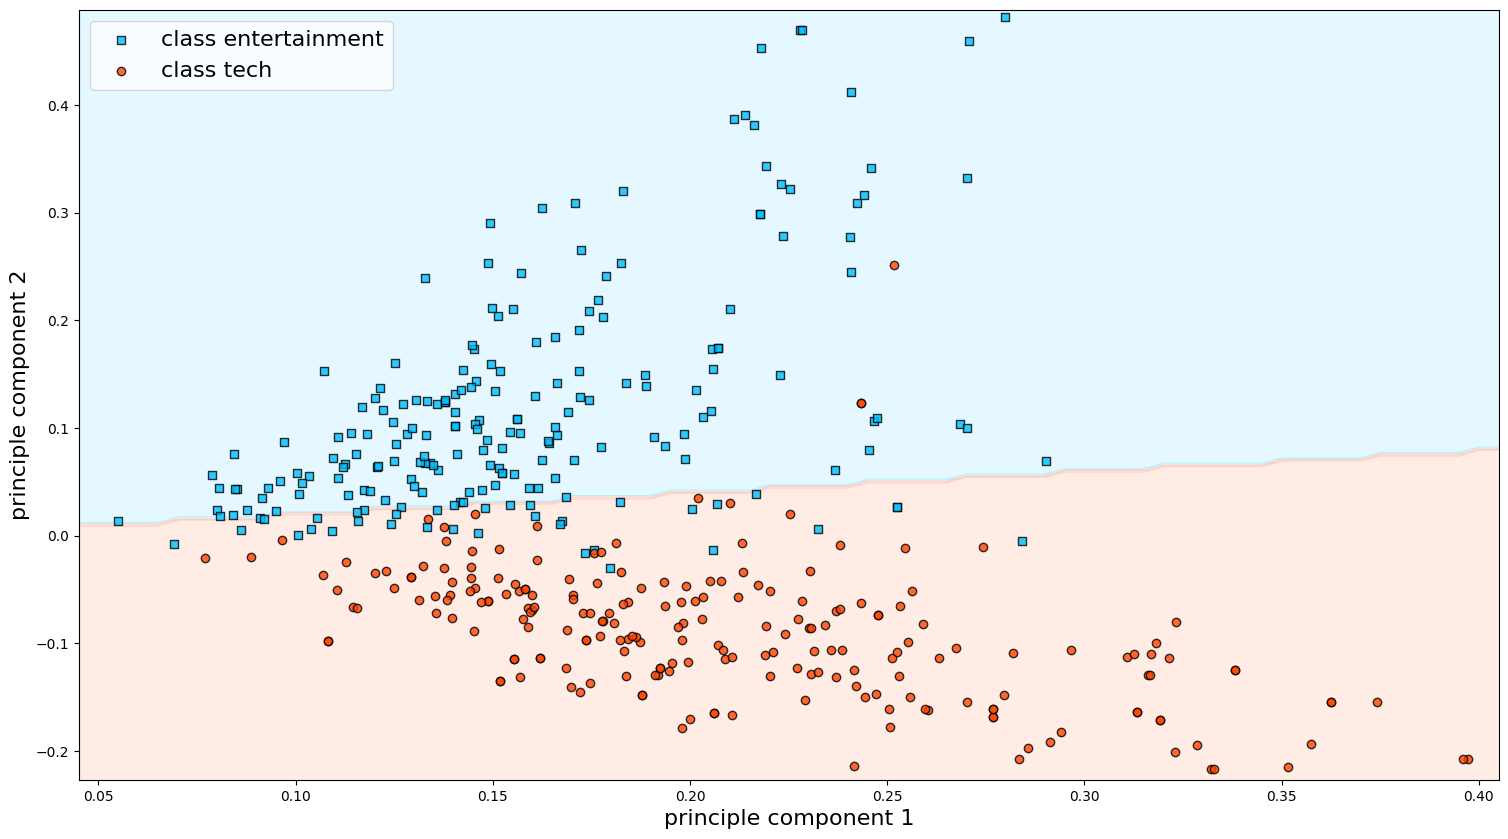

In [72]:
pca_knn = TruncatedSVD(n_components=2)
pca_tfidf = pca_knn.fit_transform(X_all_tfidf)

knn_best_all = KNeighborsClassifier(n_neighbors = 28, metric = "euclidean")
knn_best_all.fit(X_all_tfidf, y_all)



fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_tfidf,y_all, ax_pca, knn_best_all)



## Impact of k on the decision boundary

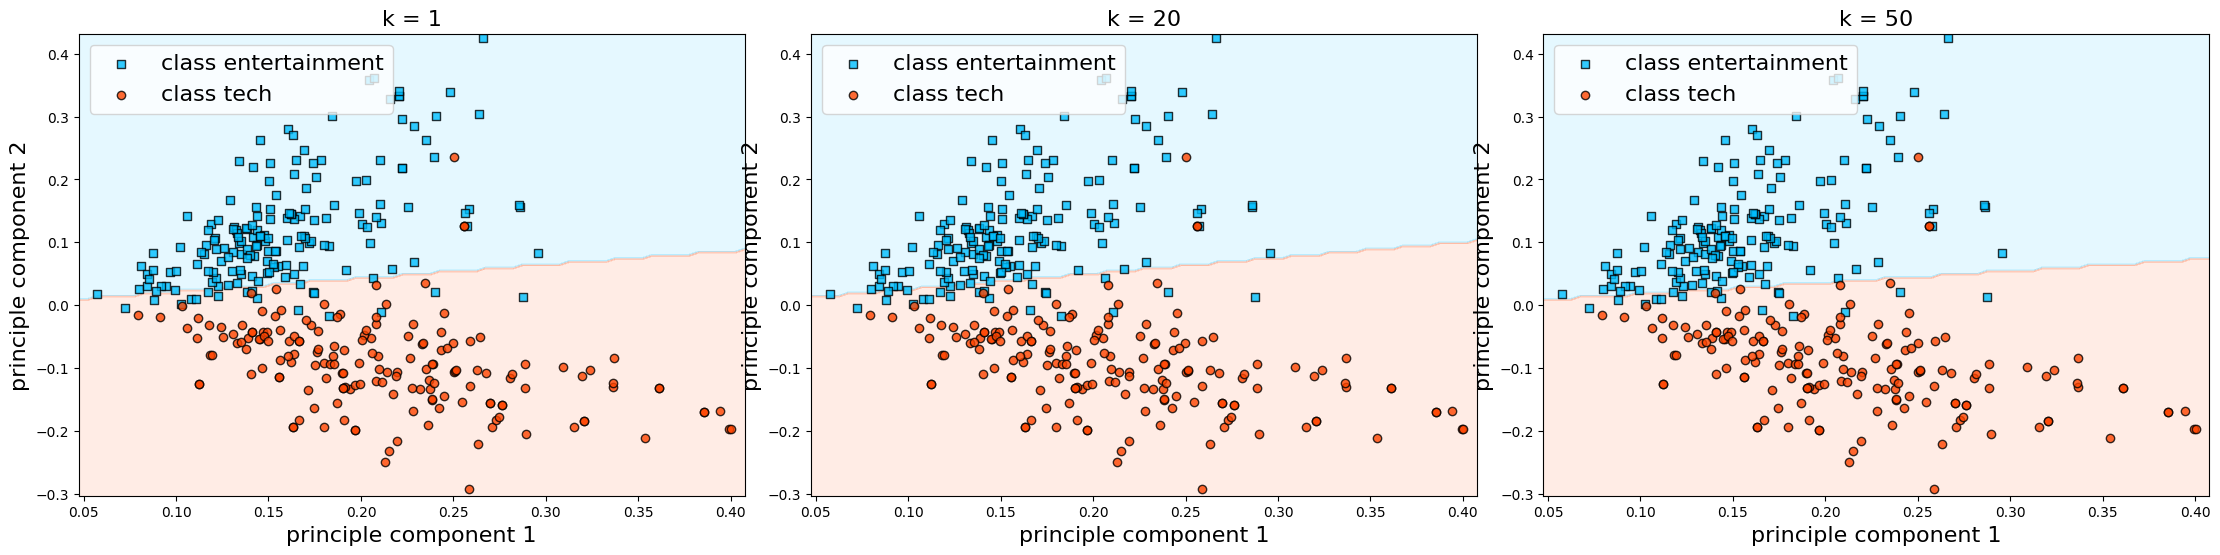

In [46]:
pca_knn = TruncatedSVD(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(X_train_tfidf)

fig, ax = plt.subplots(1, 3, figsize=(24, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, k in zip(ax, [1, 20, 50]): 
    model = KNeighborsClassifier(n_neighbors=k, metric="euclidean").fit(X_train_tfidf, y_train)
    plot_decision_regions(pca_knn, pca_train_tfidf, y_train, axi, model)
    axi.set_title(f'k = {k}', size=16)





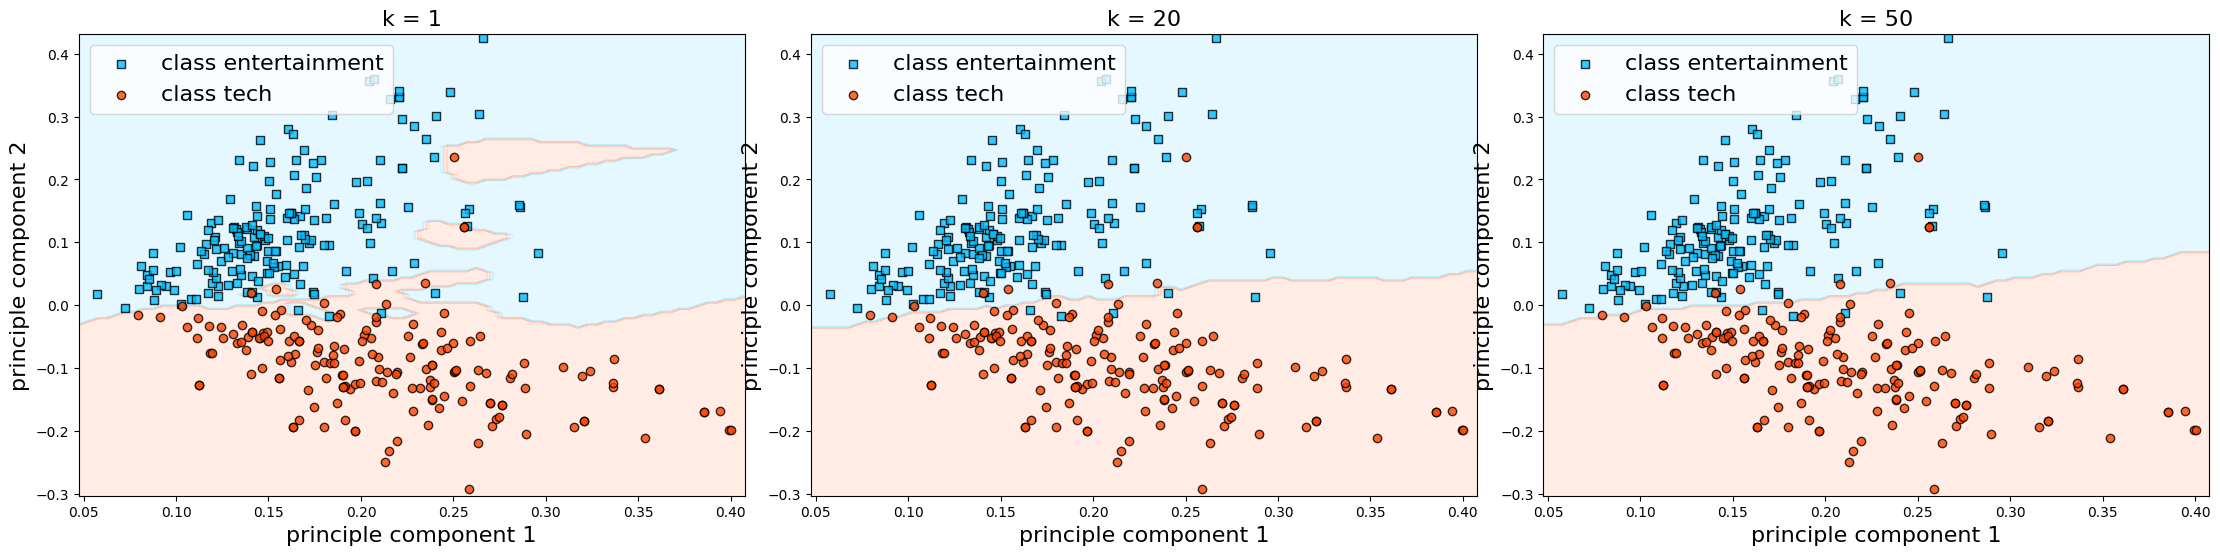

In [41]:
pca_knn = TruncatedSVD(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(X_train_tfidf)

fig, ax = plt.subplots(1, 3, figsize=(24, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, k in zip(ax, [1, 20, 50]): 
    model = KNeighborsClassifier(n_neighbors=k, metric="euclidean").fit(pca_train_tfidf, y_train)
    plot_decision_regions_no_inverse(pca_train_tfidf, y_train,model, axi )
    axi.set_title(f'k = {k}', size=16)

----older code for knn--

In [10]:
#best_k = 20
# best_metric = cosine
# train a knn classifier with the optimal parameters 
knn_best = KNeighborsClassifier(n_neighbors = best_k, metric = best_metric)
knn_best.fit(X_train_count, y_train)

y_pred_knn = knn_best.predict(X_test_count)

print("K-Nearest Neighbor:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbor:
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

entertainment       0.95      0.92      0.93        38
         tech       0.94      0.96      0.95        48

     accuracy                           0.94        86
    macro avg       0.94      0.94      0.94        86
 weighted avg       0.94      0.94      0.94        86



## Soft SVM

In [17]:
# soft SVM


# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_count, y_train)

y_pred_linear = linear_svm.predict(X_test_count)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_linear))
print('Classification Report:')
print(classification_report(y_test, y_pred_linear))

Best C parameter: 0.01
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



# Soft svm tfidf

In [18]:
# soft SVM


# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_tfidf, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_tfidf, y_train)

y_train_linear = linear_svm.predict(X_train_tfidf)
y_test_linear = linear_svm.predict(X_test_tfidf)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_test_linear))
print('Classification Report:')
print(classification_report(y_test, y_test_linear))

Best C parameter: 1
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



(62, 54)


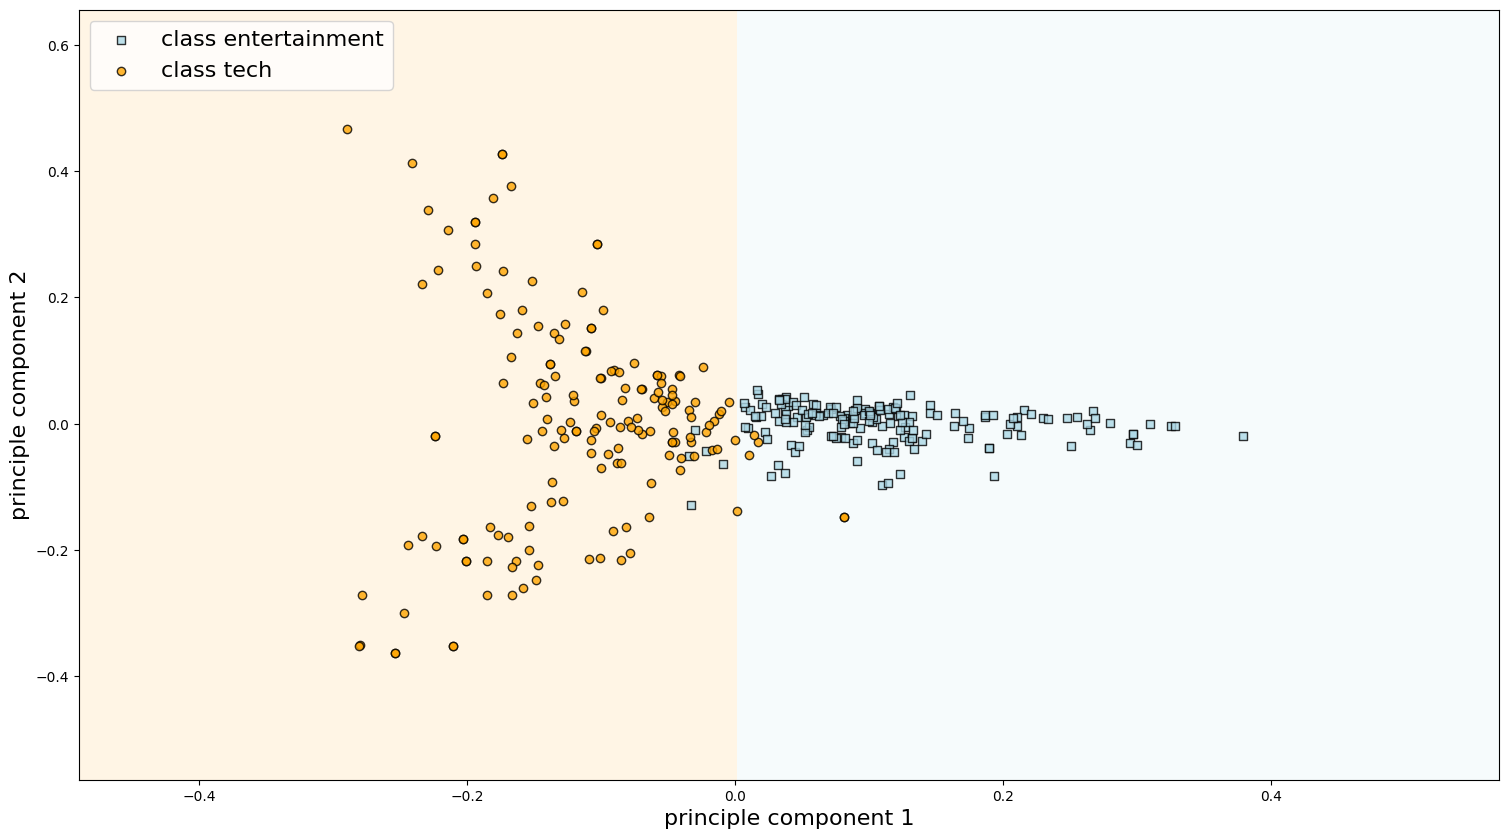

In [19]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_train_tfidf, y_train_linear, ax_pca, linear_svm, test_idx=None, resolution=0.02)


(56, 38)


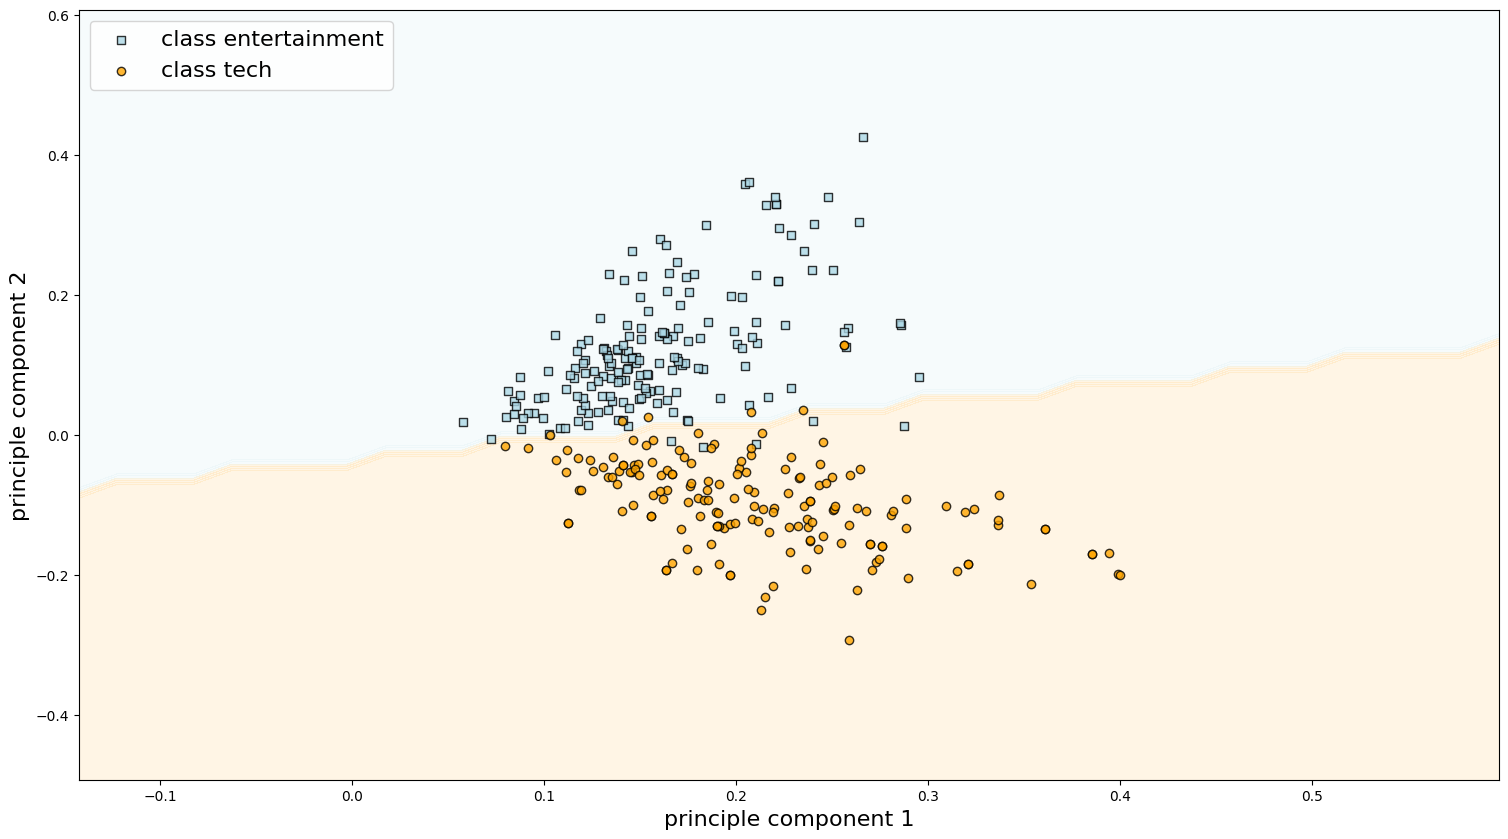

In [20]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn_trunc, pca_train_tfidf_trunc, y_train_linear, ax_pca, linear_svm, test_idx=None, resolution=0.02)


#### Hard-Margin RBF with varying kernel width


In [21]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_count, y_train)

y_pred_rbf = rbf_svm.predict(X_test_count)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 0.001
Hard-Margin RBF SVM:
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [22]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_tfidf, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_tfidf, y_train)

y_train_rbf = rbf_svm.predict(X_train_tfidf)
y_pred_rbf = rbf_svm.predict(X_test_tfidf)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 1
Hard-Margin RBF SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



(62, 54)


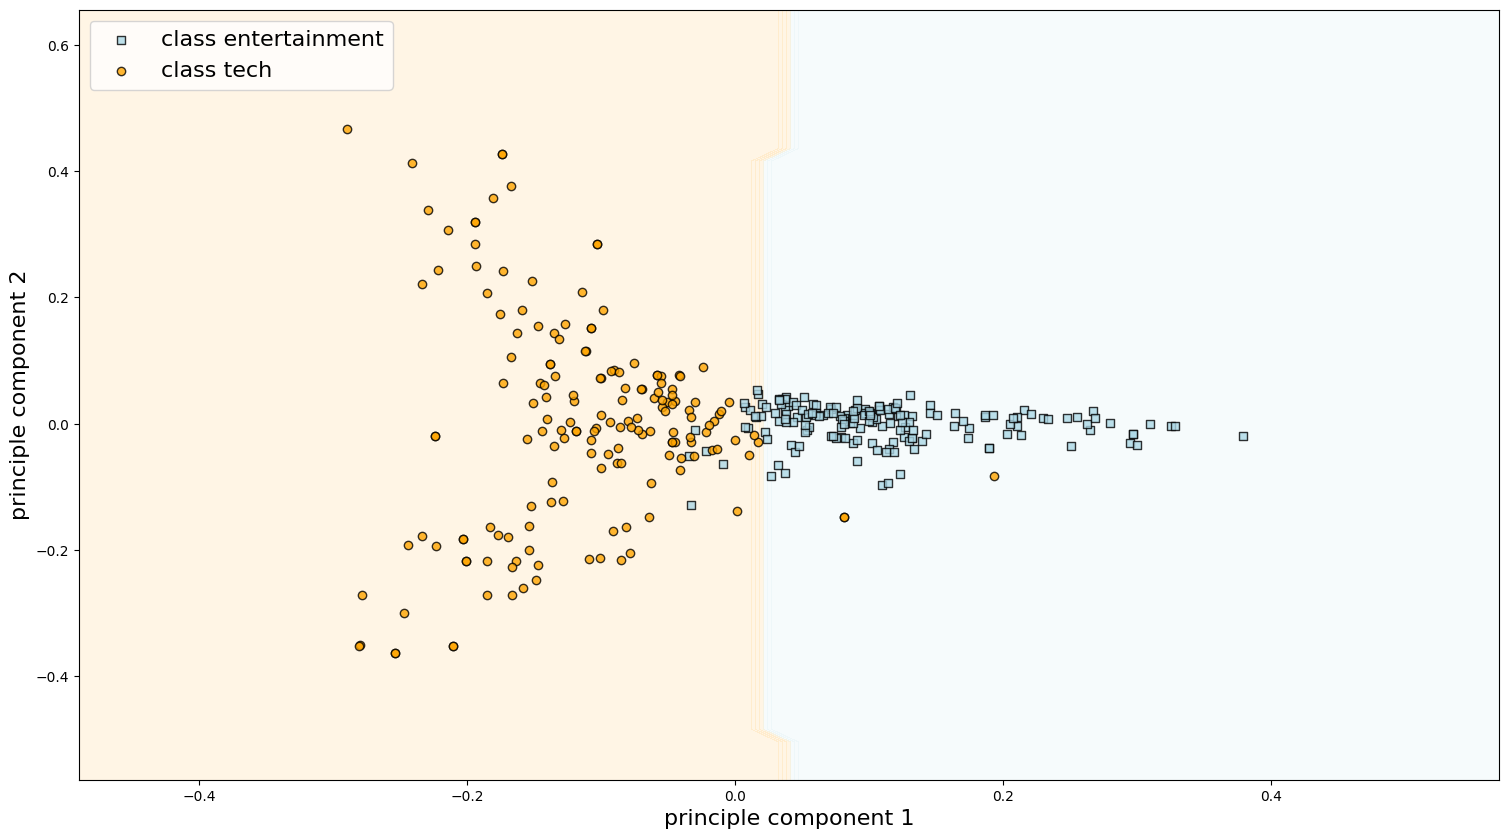

In [23]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_train_tfidf, y_train_rbf, ax_pca, rbf_svm, test_idx=None, resolution=0.02)


(56, 38)


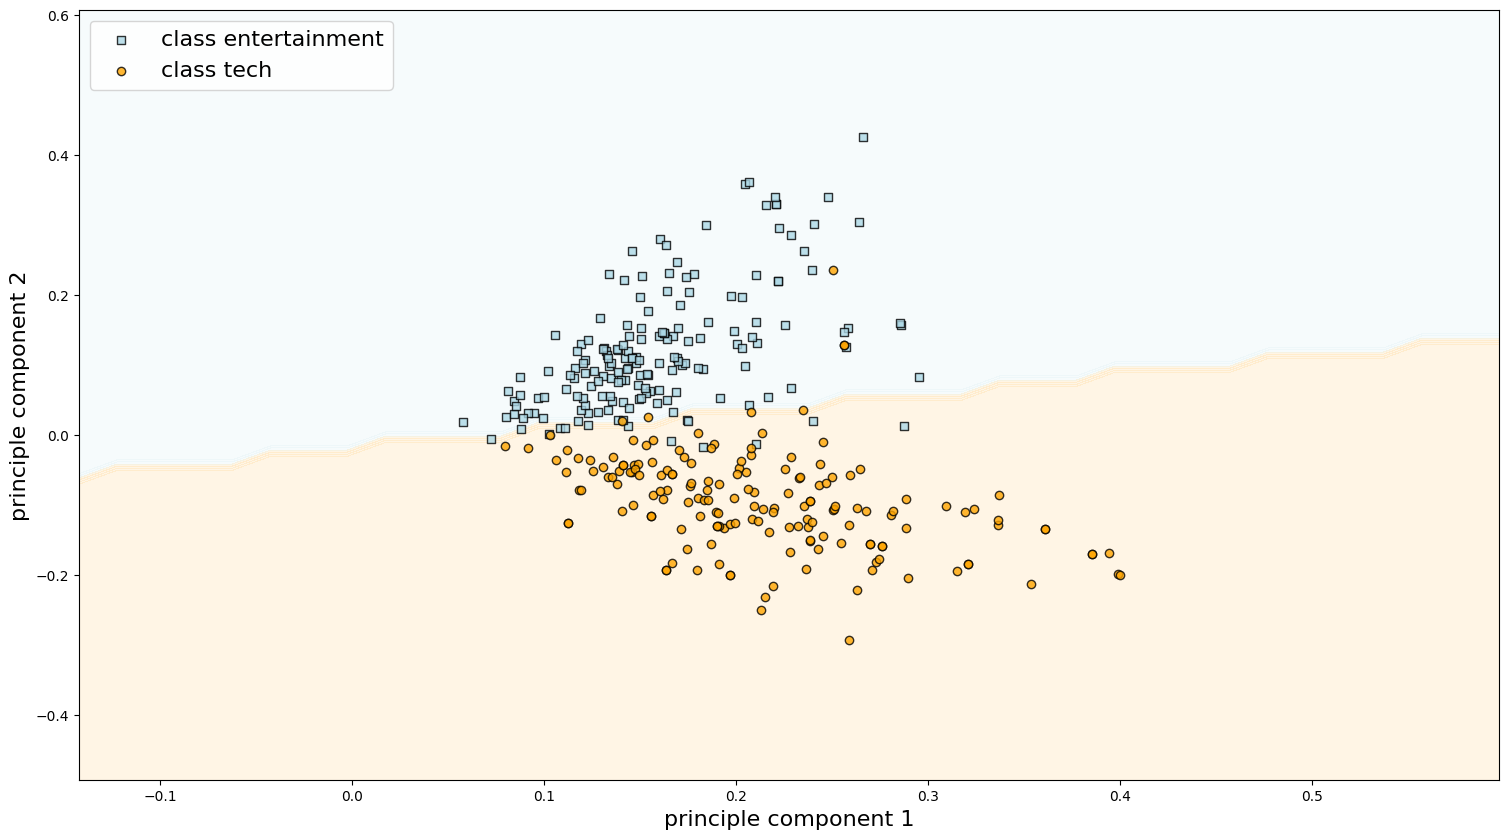

In [24]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn_trunc, pca_train_tfidf_trunc, y_train_rbf, ax_pca, rbf_svm, test_idx=None, resolution=0.02)


## The impact of the kernel hyperparameter on  Hard SVM

In [16]:



clf = make_pipeline(TfidfVectorizer(), SVC(kernel='rbf', gamma = 0.1))

scores = cross_validate(clf, X_train, y_train, scoring='f1', pos_label = "tech", cv=5, return_train_score=False)
print(scores) 

TypeError: got an unexpected keyword argument 'pos_label'

### d) Neural Network

/home/jffrysith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jffrysith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jffrysith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


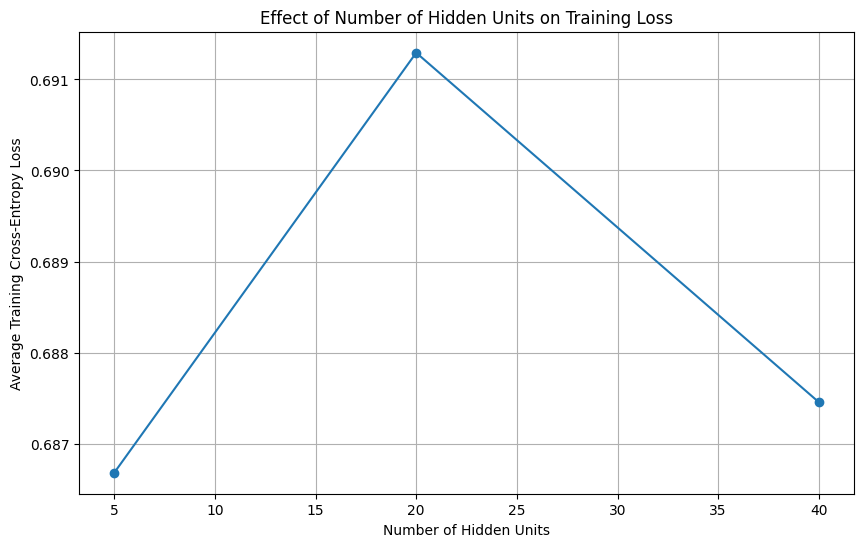

In [25]:

#define hyperparameters
learning_rate_init = 0.01
max_iter = 100
hidden_units_list = [5, 20, 40]

average_training_losses = []

for hidden_units in hidden_units_list:
    #initialize MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(hidden_units,),
                        activation='relu',
                        solver='sgd',
                        learning_rate_init=learning_rate_init,
                        max_iter=1, 
                        warm_start=True, 
                        random_state=42)
    
    #weight initialization
    def init_weights(m):
        if isinstance(m, MLPClassifier):
            for layer in m.coefs_:
                layer[:] = np.random.uniform(0, 0.1, layer.shape)
                
    mlp._fit(X_train_tfidf, y_train)
    init_weights(mlp)
    
    training_losses = []
    
    for epoch in range(max_iter):
        mlp.partial_fit(X_train_tfidf, y_train, classes=np.unique(y_train))
        y_train_pred = mlp.predict_proba(X_train_tfidf)
        loss = log_loss(y_train, y_train_pred)
        training_losses.append(loss)
    
    average_training_loss = np.mean(training_losses)
    average_training_losses.append(average_training_loss)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_units_list, average_training_losses, marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Training Cross-Entropy Loss')
plt.title('Effect of Number of Hidden Units on Training Loss')
plt.grid(True)
plt.show()


## Task 3: Classification Quality Evaluation

Naive Bayes model: with split = 0.1 has Accuracy: 0.9433962264150944
Naive Bayes model: with split = 0.3 has Accuracy: 0.9834710743801653
Naive Bayes model: with split = 0.5 has Accuracy: 0.9888888888888889
Naive Bayes model: with split = 0.7 has Accuracy: 0.9908256880733946
Naive Bayes model: with split = 0.9 has Accuracy: 1.0
KNN model: with split = 0.1 has Accuracy: 0.8868501529051988
KNN model: with split = 0.3 has Accuracy: 0.9551020408163265
KNN model: with split = 0.5 has Accuracy: 0.9726775956284153
KNN model: with split = 0.7 has Accuracy: 0.9557522123893806
KNN model: with split = 0.9 has Accuracy: 0.9473684210526315
SVM model: with split = 0.1 has Accuracy: 0.9128919860627178
SVM model: with split = 0.3 has Accuracy: 0.918918918918919
SVM model: with split = 0.5 has Accuracy: 0.9349112426035503
SVM model: with split = 0.7 has Accuracy: 0.9514563106796117
SVM model: with split = 0.9 has Accuracy: 0.9714285714285714
Neural Network model: with split = 0.1 has Accuracy: 0.993377

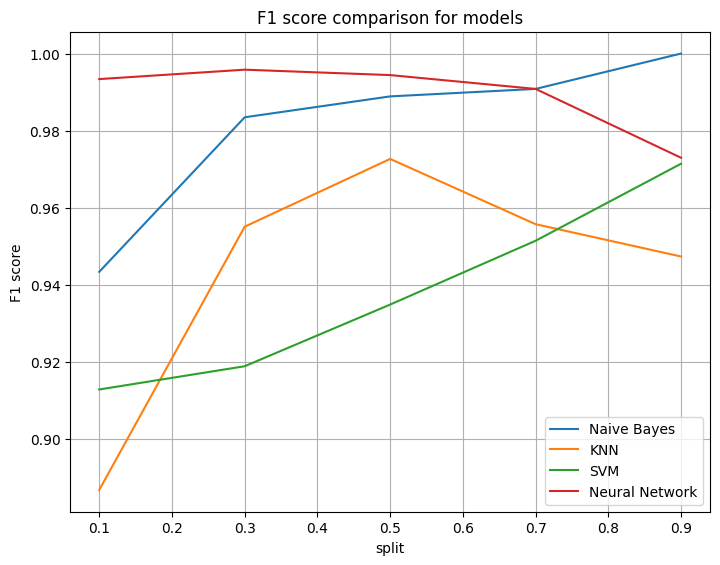

In [62]:
# removes the annoying deprecation warnings that are being a pain to read lol

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn




splits = [0.1, 0.3, 0.5, 0.7, 0.9]

models = {"Naive Bayes": NBmodel, "KNN": knn_best, "SVM": linear_svm, "Neural Network": mlp}


all_data = X_train_count
all_labels = y_train

results = {}
for name in models.keys():
    for split in splits:
        X_train, X_verify, y_t, y_verify = train_test_split(all_data, all_labels, test_size= 1-split,random_state=42)
        
        models[name].fit(X_train, y_t)
        y_pred = models[name].predict(X_verify)

        measure = f1_score(y_verify, y_pred, pos_label = 'tech')

        results[name] = results.get(name, [[],[]])
        results[name][0].append(split); results[name][1].append(measure)
        print(f'{name} model: with split = {split} has Accuracy: {measure}')

print(results)

fig = plt.figure()
ax = fig.add_axes((0,0,1,1))
for name in models.keys():
    ax.plot(results[name][0], results[name][1], label = name)
ax.set_xlabel("split")
ax.set_ylabel("F1 score")
ax.set_title("F1 score comparison for models")
plt.legend()
plt.grid()
plt.show()



(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.


Train on train data

Predict on testing data: test once for each model




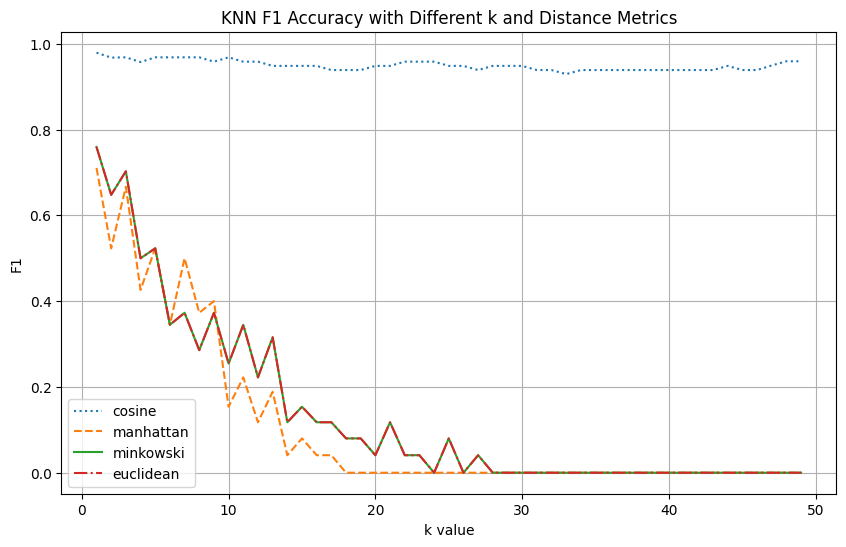

In [60]:
# graph of accuracy with different k and distance metrics

from sklearn import metrics

k_values = range(1, 50)
dist_metrics = ["cosine", "manhattan", "minkowski", "euclidean"]
accuracy_results = {}

for metric in dist_metrics:
    accuracy_results[metric] = []
    knn = KNeighborsClassifier(metric = metric)
    for k in k_values:
        knn.n_neighbors = k
        knn.fit(X_train_count, y_train)
        y_pred = knn.predict(X_test_count)
        # print(metrics.f1_score(y_test, y_pred,average="binary", pos_label="tech") )
        measure = f1_score(y_test, y_pred,average="binary", pos_label="tech")
        accuracy_results[metric].append(measure)

plt.figure(figsize = (10, 6))
line_styles = [":", "--", "-", "-."]
for metric, accuracy_val, style in zip(accuracy_results.keys(), accuracy_results.values(), line_styles):
    plt.plot(k_values, accuracy_val, label = metric, linestyle = style)
plt.xlabel("k value")
plt.ylabel("F1")
plt.title("KNN F1 Accuracy with Different k and Distance Metrics")
plt.legend()
plt.grid(True)
plt.show()


When k is small, there is significant variability in the accuracy of the KNN model across all distance metrics. This is because a smaller k value means that the classifier is more sensitive to noise in the training data. As k increases, the accuracy tends to stabilize. The accuracies for manhattan, minkowski and euclidean distance metrics decrease gradually as k increases, converging to a stable but low value. Meanwhile, the accuracy of the cosine distance metric remains relatively high (> 0.9), suggesting that it is more robust to changes in k and can maintain high accuracy regardless of the value of k.


(c) Report and compare your NB, kNN, SVM and NN classifiers with the best hyperparameter
settings. Summarize what you have observed in the classification accuracy in 𝐹𝐹1 measure on
the testing dataset. 